# Sto learning 


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

device = set_device(verbose=True)

cuda available


# MNIST

In [2]:
# Downloads the dataset if not found locally
from mnist import check_mnist_dataset_exists, datasampler, MNISTDataset

_ = check_mnist_dataset_exists()

nb_selected_train_data = 55000
nb_selected_test_data = 10000

train_data, train_labels, test_data, test_labels, val_data, val_labels= datasampler(
    nb_selected_train_data, nb_selected_test_data
)

trainset = MNISTDataset(train_data, train_labels, lattice_type=0)
valset = MNISTDataset(val_data, val_labels)
testset = MNISTDataset(test_data, test_labels)

## Visualise the dataset

Label: tensor(0.)
graph: DGLGraph(num_nodes=784, num_edges=3024,
         ndata_schemes={}
         edata_schemes={})
Largest eigenvalue: (2.000000000000003+0j)
Smallest eigenvalue: (1.5543122344752192e-15+0j)


/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


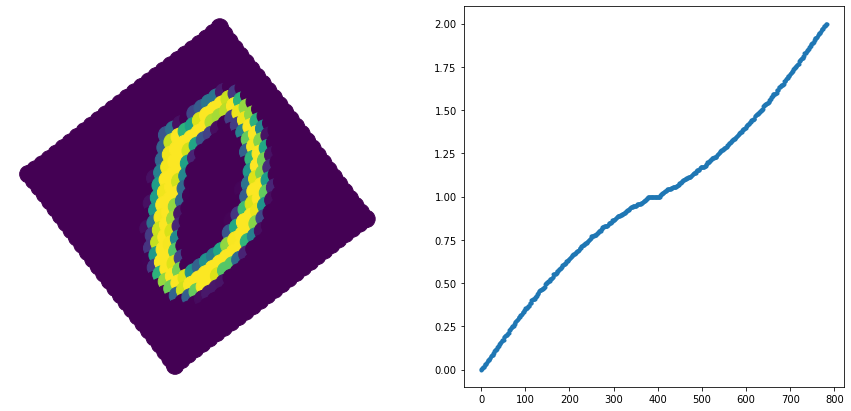

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo , s_demo= valset[random.randrange(5000)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),node_color=s_demo)
print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()



# Model definition for training

In [4]:
from model import DGL_mean_Classifier, Classifier, DGL_global_pooling_Classifier
# model_parameters
in_features = 1
first_conv_out = 64
second_conv_out = 128
hidden_layer_classifier = 250
k = 5
n_classes = 10

net = DGL_mean_Classifier(
    in_features, 
    first_conv_out, 
    second_conv_out, 
    hidden_layer_classifier, 
    n_classes, 
    k,
    readout="max"
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=64, bias=False)
        (1): Linear(in_features=1, out_features=64, bias=False)
        (2): Linear(in_features=1, out_features=64, bias=False)
        (3): Linear(in_features=1, out_features=64, bias=False)
        (4): Linear(in_features=1, out_features=64, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=64, out_features=128, bias=False)
        (1): Linear(in_features=64, out_features=128, bias=False)
        (2): Linear(in_features=64, out_features=128, bias=False)
        (3): Linear(in_features=64, out_features=128, bias=False)
        (4): Linear(in_features=64, out_features=128, bias=False)
      )
    )
    (2): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=128, out_features=256, bias=False)
        (1): Linear(in_features=128, out_features=256, bias=False)
        (2): L

In [5]:
from utils import load_model
net.load_state_dict(load_model('Cheb_max_orig_cone'))

<All keys matched successfully>

# Training pipe

In [23]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=50,
                         shuffle=True, collate_fn=collate, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=200,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=200,
                         shuffle=False, collate_fn=collate, drop_last=True, pin_memory=False)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (data, label, signal) in enumerate(data_loader):
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, 
                           signal.float().view(-1, 1).to(device),
                           (torch.ones(200)*2).to(device))
            loss = loss_func(output, label.long().to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1
        
        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {} loss - train {:.4f} - val {:.4f} - Acc: {} ({:.1f}%) in {:.1f}s".format(
                epoch, epoch_loss, val_loss, correct,
            100 * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [8]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (data, label, signal) in enumerate(data_loader):
            
            data, label, signal = data.to(device), label.to(device), signal.to(device)

            output = model(data, signal.view(-1, 1).float(), (torch.ones(200)*2).to(device))
            if verbose and iter == 0:
                #print(output[0:5], output.size())
            # sum up batch loss
            test_loss += loss_func(output, label.long().to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [24]:
train(net, device, train_loader, 20, loss_func,optimizer, scheduler)

Epoch 0 loss - train 0.0734 - val 0.3820 - Acc: 53921 (98.0%) in 194.3s
Epoch 1 loss - train 0.0751 - val 0.4316 - Acc: 53870 (97.9%) in 194.7s
Epoch 2 loss - train 0.0681 - val 0.4204 - Acc: 53922 (98.0%) in 193.8s
Epoch 3 loss - train 0.0644 - val 0.4220 - Acc: 53957 (98.1%) in 196.9s
Epoch 4 loss - train 0.0574 - val 0.3844 - Acc: 54098 (98.4%) in 197.5s
Epoch 5 loss - train 0.0788 - val 0.4203 - Acc: 53827 (97.9%) in 197.2s
Epoch 6 loss - train 0.0502 - val 0.3971 - Acc: 54175 (98.5%) in 197.2s
Epoch 7 loss - train 0.0578 - val 0.3949 - Acc: 54070 (98.3%) in 196.2s
Epoch 8 loss - train 0.0600 - val 0.4582 - Acc: 54025 (98.2%) in 197.8s
Epoch 9 loss - train 0.0593 - val 0.3939 - Acc: 54055 (98.3%) in 198.1s
Epoch 10 loss - train 0.0618 - val 0.3779 - Acc: 54027 (98.2%) in 199.4s
Epoch 11 loss - train 0.0429 - val 0.3852 - Acc: 54284 (98.7%) in 199.2s
Epoch 12 loss - train 0.0650 - val 0.4635 - Acc: 53993 (98.2%) in 200.1s
Epoch 13 loss - train 0.0504 - val 0.3915 - Acc: 54185 (98.5%

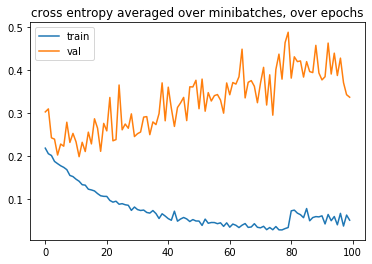

In [25]:
plt.title("cross entropy averaged over minibatches, over epochs")
plt.plot(epoch_losses)
plt.legend(['train','val'])
plt.show()

In [26]:
torch.cuda.empty_cache()

## Test Metrics

In [27]:
test(net,device,test_loader)

tensor([[ -44.5519,  -13.5240,  -18.4117,  -26.9527,  -33.4864,  -12.7335,
          -37.2657,   26.6536,  -52.4619,  -44.8878],
        [ -17.7081,  -30.0263,   11.6979,  -12.3025,  -27.5288,   -0.7682,
          -22.0146,  -22.0666,  -38.7004,  -23.6264],
        [-223.3412,   24.5092,  -98.8897,  -88.0307,  -88.0685, -114.3250,
         -110.5234,  -75.1896, -155.1608, -152.7197],
        [  32.2108, -188.1305,  -40.4105,  -57.8675,  -42.8681,  -42.3133,
          -18.7215,  -41.4345,  -43.2840,   -7.6088],
        [ -31.7747,  -33.8342,    3.1639,  -25.6427,   14.3939,  -21.9377,
          -23.6654,  -14.9772,  -47.7390,   -9.3403]], device='cuda:0') torch.Size([200, 10])

 Average loss per epoch: 0.4456, Accuracy: 9323/10000 (93%)

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       980
         1.0       0.98      0.99      0.98      1135
         2.0       0.85      0.91      0.88      1032
         3.0       0.95      0.92   

## Saving

In [28]:
from utils import save_model

save_model("Cheb_max_orig_overfit", net)